# Building CNNs for photo classification using PyTorch: An introduction 

In this notebook, we build a Convolution Neural Network (CNN) to classify bird species from images using PyTorch

Assumed background: Beginners in Machine Learning, some basic python knowledge (although not mandatory)

## Introduction
Image classification is a common and very useful technique in computing, and the skill is becoming more in demand from an employability perspective. Before we begin, below is a quick overview of the dataset we will be using and how we will build the CNN: 

Convolutional Neural Networks (CNNs) are a machine learning technique that "learns" to recognise patterns in images such as edges, shapes, colours (known as features) on a training set of data. It then uses what is has learnt to make predictions on an unseen ("Test") set of data. 

Dataset:
- We will use the Birds classification dataset from Rahma Sleam, Kaggle.
- There are 6 types of bird we need to predict, these are called "classes" or "Targets" as they are what we want to predict givien the features of an image.
    - American Goldfinch
    - Barn Owl
    - Carmine Bee-Eater
    - Downy Woodpecker
    - Emperor Penguin
    - Flamingo
- All these birds have their own distinct features as they range over across a wide range of habitats - see link for more detail.
- This will be very beneficial for our CNN

We Will:
- Load an image dataset
- Explore how the dataset is distributed among each class (ie, how many images there are for each dataset)
    - This will help us limit any biases
- Apply preprocessing and augmentation
- Train a CNN
- Evaluate its performance

_Link to dataset: https://www.kaggle.com/datasets/rahmasleam/bird-speciees-dataset All rights to their respective owners_

## Importing Libraries
Here, we import the revelent packages from PyTorch, Torchvision and some useful python libraries that will help us to visualise and manipulate data

In [1]:
## Importing Libraries 
## To be updated to be stored in a dependancies folder
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets

## Device allocation
PyTorch (The python library we will be using to build and run the CNN) can run on either your machine's CPU or CUDA (Nvidia's parallel computing platform). CUDA generally provides a faster runtime for CNN models. 

The code below searches to see if CUDA is available and switches to it if possible. If GPU Available: None, do not worry as the notebook will still be able to run

In [2]:
## Which device?
print(">>> Device\nGPU Available: ", torch.cuda.is_available())

## Setting Device
if torch.cuda.is_available() == False:
    print("Switching to CPU.... \nMay result in slower performance")
    device = "cpu"
else:
    print("Cuda GPU found, switching device to increase performance")
    device = "cuda"

>>> Device
GPU Available:  False
Switching to CPU.... 
May result in slower performance


## Transforms and augmentation
Before we load the data we need to define how we intend to preprocess the data.

Neural networks, especially CNNs, perform better when images are the same size and normalised. 

Augmenting the images helps the model to generalise as it adds randome horizontal flips and random orientations to the images.

In [3]:
## Transforms, inspired by class notes
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])  

## Loading the dataset

To load the dataset, we use torchvision.datasets.ImageFolder which assumes:
- One folder per class
- Images are inside each folder

Then, it is good practice to investigate how the data is distributed among each class. This will help us to determine whether we need to eliminate any biases

In [4]:
data_path = "../../../Data_birds/birds_dataset/Bird Speciees Dataset/"

## Loading the total data 
data = torchvision.datasets.ImageFolder(
    ## Loading data usng Image Folder
    ## Root: where the data is stored
    ## Transform: applies the transforms / augmentations we defined earlier
    root = data_path,
    transform = transform,
)

## Investigating distribution
classes = data.classes
print(">>> Investigating distribution")
## Counter counts how may times each bird appears
class_counts = Counter(data.targets)
for index, count in class_counts.items():
    ## Loops through each class index and its image count
    print(f"{data.classes[index]} : {count}")

>>> Investigating distribution
AMERICAN GOLDFINCH : 143
BARN OWL : 129
CARMINE BEE-EATER : 131
DOWNY WOODPECKER : 137
EMPEROR PENGUIN : 139
FLAMINGO : 132


The distribution is fairly even, we will continue wihtout any further modifications. 

CNNs may struggle with classes of fewer images as they will not be trained on enough variety.
To overcome this, either increase sample size by taking more data, or artificially increase sample size of one class through augmentation

## Train / Test Split

We now will split the dataset into a 80% : 20% split for training and testing
- 80% of the total data will be used to train the model
- 20% of the total data will be used to test the model and produce accuracy scores

This is common practice in ML because:
- It can help to ensure that the CNN is not simply memorising patterns from training. This helps to prevent overfitting:
- Overfitting occurs when the CNN fits the training data too closely, that it cannot provide good predictions on unseen data

Batch size is a training hyperparameter that defines how many samples a neural network processes at once, before updating its weights during training. Here, it is set to 16. 

In PyTorch, data is loaded through something called Dataloaders which do the following:
- Load the data in batches
- Shuffle training data
- Improve perfomance

In [5]:
## Setting batch size to 16
## Model will process 16 images at a time before updating its weights
batch_size = 16
print(">>> Splitting data into 80% training and 20% testing")

## Calculating the training and testing sizes
## Note: test_size best not be deinfed as int(0.2 * len(data)) due to potential rounding error
## random_split: sing PyTorch's built in random splitter
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train_dataset, test_dataset = random_split(data, [train_size, test_size])

train_loader = DataLoader(
    ## Loading training set
    ## shuffle: randomly shuffles the data during training
    ## num_workers = 0: loads data using main process, no parallel loading (sciserver friendly)
    train_dataset,
    batch_size = batch_size,
    shuffle = True,
    num_workers = 0
)

test_loader = DataLoader(
    ## Loading testing set
    ## shuffle: keeps data consecutive during testing
    ## num_workers = 0: loads data using main process, no parallel loading (sciserver friendly)
    test_dataset,
    batch_size = batch_size,
    shuffle = False,
    num_workers = 0
)
print(">>> Complete")

>>> Splitting data into 80% training and 20% testing
>>> Complete


## Visualising data

Its common practice to visualise the data before training your CNN. This has many benefits:
- Ensure the images are loading correctly
- To visualise how the data is being augmentated - useful when troubleshooting ie if the intensity needs to be higher / lower
- To ensure that the images are the same size

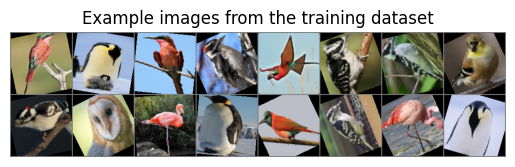

>>> Notice how there are 16 images (defined from the batch_size), and that each time there is a different set of images (as data is shuffled)


In [6]:
def imshow(img):
    ## Helper function to load image
    ## img: Reverses the normalisation applied in the transform 
    ## npimg: Covnerts PyTorch tensor to np.array - readabl by matplotlib
    ## np.transpose: Ensures that the height, width, channels are in correct order
    ## plt.imshow(...): Load image grid
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.axis("off")
    plt.title("Example images from the training dataset")
    plt.show()
    
## Calling helper function and choosing images from first data batch
## dataiter: Converts train_loader to an iterator - allow fetching of batches
## images, labels = next(dataiter: Gets the first batch)
## imshow(...): Calls function above to show images
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print(">>> Notice how there are 16 images (defined from the batch_size), and that each time there is a different set of images (as data is shuffled)")

## Defining CNN Architecture
Now we begin to define our CNN, which consists of layers that have different purposes:
- Convolutional layers
    - Extract features from the image
- Pooling laters
    - Downsizes the image through splitting the image into grids
    - Takes the average or the max of values in each grid
- Fully connected layers
    - Uses outputs from pooling layers to train
- Relu activation function
    - Defines whether a neuron should "fire" or not
    - Ie, whether a decision is carried forward to the next layer or not
    - Can have different activation functions that effect model convergence

In [7]:
## Defining a CNN - Inspiried by class notes. Relu activation function - See Q3 for variations
print(">>> Defining CNN Architecture")
class Net(nn.Module):
    ## Definition of CNN Architecture
    ## Net(nn.Module) creates a custom CNN from PyTorch
    def __init__(self, num_classes = 6, input_size=128):
        ## num_classes = 6: There are 6 types of bird
        ## input_size = 128: Input images been resized to 128
        ## super().__init__(): Initialisation
        ## Definition of convolutional layers
            ## conv1: Input 3 channels (RGB), outputs 6 feature maps, 5x5 kernel
            ## pool: Max pooling: reduces spatial dimensions by taking the maximum value for every 2x2 grid
            ## conv2: Input 6 channels, output 16 channels, 5x5 kernel
        ## Definition of Fully Connected Layers
            ## fc1: 16*29*29 input features (comes from size of feature maps after conv layers), 120 outputs
            ## fc2: 120 inputs, 84 outputs
            ## fc3: 84 inputs, 6 outputs (classes)
            
        super().__init__()
        
        ## Convolutional layers
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        
        ## FN layers
        self.fc1 = nn.Linear(16*29*29, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)
        
    def forward(self, x):
        ## Forward defines how data flows through a network
        ## X goes through:
            ## conv layer 1
            ## conv layer 2
            ## Image gets flattened to a vector for the FC layers
            ## FC Layer 1
            ## FC Layer 2
            ## FC Layer 3 - this is the output layer
    
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        x = self.fc3(x)
        return x
    
## Initiate Network
net = Net(num_classes=6)
print("\n>>> Completed")

>>> Defining CNN Architecture

>>> Completed


## Defining Loss and Optimizer
We use:

Loss function: How the model compares with results, aim is to minimise this function. Here, we use CrossEntropyLoss

Optimiser: Method that updates the models weights (strength of connection between neurons) based on the loss function above. Here, we use ADAM optimiser (as SGD was found to be inferior). Learning rate controls the size of steps taken to minimise the loss function

We also print out the layers of the CNN

In [8]:
print(">>> Defining Cross Entropy Loss and Adam optimiser (learning rate = 0.001)")

## Defining cross entropy loss and adam optimiser
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

print("\n>>>CNN Network Layer Description")
net.to(device)

>>> Defining Cross Entropy Loss and Adam optimiser (learning rate = 0.001)

>>>CNN Network Layer Description


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=13456, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=6, bias=True)
)

## Training Loop
Here is where we train our CNN through a loop for 10 epochs. One epoch would mean that the CNN would go through the data once, so 10 epochs mean the CNN goes through the data 10 times. 


In [9]:
print(">>> Training network, 10 epochs")

for epoch in range(10):
    ## Training loop - this is where the model trains on the data
    ## Epoch: How many times teh model goes through the training set
    ## running_loss: tracks the loss
    running_loss = 0.0
    
    for i, (inputs, labels) in enumerate(train_loader):
        ## Loops over training data
        ## inputs = image batch, labels = corresponding classes
        ## inputs.to(device) / labels.to(device) moves the current batch to the device chosen
        ## optimiser.zero_grad() resets the loss gradient
        ## outputs = net(inputs) sends data through CNN
        ## Definition of loss function as defined above
        ## loss.backward(): Computes the loss and finds which neurons contributed most 
        ## optimiser.step(): Adam optimiser updates the model weights 
        ## running_loss(): Tracks the running loss
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        ## Print loss every 10 batches
        if (i+1) % 10 ==0:
            print(f"Epoch {epoch+1}, Batch {i+1} Loss: {running_loss / 10:.3f}")
            running_loss = 0.0
        
        ## Loop now starts again
    ## Entire loop now repeats for 10 epochs
    
print("\n>>> Finished Training")

>>> Training network, 10 epochs
Epoch 1, Batch 10 Loss: 1.750
Epoch 1, Batch 20 Loss: 1.439
Epoch 1, Batch 30 Loss: 1.208
Epoch 1, Batch 40 Loss: 1.096
Epoch 2, Batch 10 Loss: 0.779
Epoch 2, Batch 20 Loss: 0.590
Epoch 2, Batch 30 Loss: 0.722
Epoch 2, Batch 40 Loss: 0.523
Epoch 3, Batch 10 Loss: 0.445
Epoch 3, Batch 20 Loss: 0.456
Epoch 3, Batch 30 Loss: 0.427
Epoch 3, Batch 40 Loss: 0.360
Epoch 4, Batch 10 Loss: 0.332
Epoch 4, Batch 20 Loss: 0.318
Epoch 4, Batch 30 Loss: 0.407
Epoch 4, Batch 40 Loss: 0.265
Epoch 5, Batch 10 Loss: 0.232
Epoch 5, Batch 20 Loss: 0.215
Epoch 5, Batch 30 Loss: 0.379
Epoch 5, Batch 40 Loss: 0.275
Epoch 6, Batch 10 Loss: 0.216
Epoch 6, Batch 20 Loss: 0.337
Epoch 6, Batch 30 Loss: 0.229
Epoch 6, Batch 40 Loss: 0.233
Epoch 7, Batch 10 Loss: 0.325
Epoch 7, Batch 20 Loss: 0.257
Epoch 7, Batch 30 Loss: 0.136
Epoch 7, Batch 40 Loss: 0.196
Epoch 8, Batch 10 Loss: 0.143
Epoch 8, Batch 20 Loss: 0.253
Epoch 8, Batch 30 Loss: 0.141
Epoch 8, Batch 40 Loss: 0.229
Epoch 9,

Now we save the model to ./bird_classifier.pth

In [10]:
## Saving the model parameters to ./bird_classifier.pth
PATH = "./bird_classifier.pth"
torch.save(net.state_dict(), PATH)
print(">>> Saved model to ./bird_classifier.pth")

>>> Saved model to ./bird_classifier.pth


## Model Testing and evaluation
Now that our model is trained, its time to test it on the testing dataset (Remember we split the data into 80% training and 20% testing). We will print out the accuract scores for each class


In [11]:
## Creating dictionaries that track predictions
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

## Testing model and saving predictions 
print(">>> Testing model")

with torch.no_grad():
    ## torch.no_grad(): Does not calculate gradient loss which is uncessisary when testing.
    for data in test_loader:
        ## loop through each batch in  the testing dataset
        ## Moves the current batch to the device
        ## outputs = net(images): Sends data through CNN
        ## torch.max: Returns class with highest predicted score for each image
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        
        for label, prediction in zip(labels, predictions):
            ## If prediction matches the true label, correct_pred increases for that class
            ## Every loop increases total_pred for that class 
            label = label.item()
            prediction = prediction.item()
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
## Accuracy = 100 * (Correct predictions) / (Total predictions) 
print(">>> Testing completed, results follow")
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

>>> Testing model
>>> Testing completed, results follow
Accuracy for class: AMERICAN GOLDFINCH is 95.8 %
Accuracy for class: BARN OWL is 68.8 %
Accuracy for class: CARMINE BEE-EATER is 90.0 %
Accuracy for class: DOWNY WOODPECKER is 100.0 %
Accuracy for class: EMPEROR PENGUIN is 93.8 %
Accuracy for class: FLAMINGO is 89.7 %


## Conclusion

In this notebook tutorial, we peformed the following:
- Loaded data from a Kaggle dataset
- Performed analysis, transforms and augmentation
- Built a CNN
- Trained it on the dataset
- Evaluated its performance on the test dataset

This notebook demonstrates full ML workflow for image classification

## Resources used in this Notebook, all respective rights to their owners

**Code inspired by**
1. Class Notes: 1st December to 5th December, Coleman K.
    - General workflow
    - Specific inspiration for the definition of 
        - Transforms
        - Loading data
        - Definition of CNN structure and training / testing
        

**Resources used for research and explanations**
1. Understanding CNN fagility when learning with imbalanced data, D. Dablain et al, 2023
    - Research into how class imbalances can effect data
    - Accessed 15/01/2026
    - Link: https://link.springer.com/article/10.1007/s10994-023-06326-9https://link.springer.com/article/10.1007/s10994-023-06326-9
2. Data Augmentation, Wikipedia, accessed 15/01/2024
    - Research into data augmentation and use for class imbalances
    - Link: https://en.wikipedia.org/wiki/Data_augmentationhttps://en.wikipedia.org/wiki/Data_augmentation
3. Understanding Train-Test Splits, C. Yudha Wijaya, Statology, accessed 15/01/2026
    - Research into why we do a test train split
    - Link: https://www.statology.org/understanding-train-test-splits/https://www.statology.org/understanding-train-test-splits/
4. What is Overfitting?, IBM,  accessed 15/01/2026
    - Definition of overfitting
    - Link: https://www.ibm.com/think/topics/overfittinghttps://www.ibm.com/think/topics/overfitting
5. Batch Size in Neural Network, Geeks for Geeks, accessed 15/01/2026
    - Definition of batch size
    - Link: https://www.geeksforgeeks.org/deep-learning/batch-size-in-neural-network/https://www.geeksforgeeks.org/deep-learning/batch-size-in-neural-network/
6. Learning Rate in Neural Network, Geeks for Geeks, accessed 15/01/2026
    - Definition of learning rate
    - Link: https://www.geeksforgeeks.org/machine-learning/impact-of-learning-rate-on-a-model/https://www.geeksforgeeks.org/machine-learning/impact-of-learning-rate-on-a-model/    
